# CSE2530 Computational Intelligence
## Assignment 3: Reinforcement Learning

<div style="background-color:#f1be3e">

_Fill in your group number **from Brightspace**, names, and student numbers._
    
|    Group   |           X          |
|------------|----------------------|
| Student A  |        XXXXXXX       |
| Student B  |        XXXXXXX       |
| Student C  |        XXXXXXX       |
| Student D  |        XXXXXXX       |

#### Imports

In [143]:
"""
You may only use numpy to implement your algorithms
You can make use of any other libraries for miscellaneous functions, e.g. to create the visual aids.
Put all of your imports in this code block.
"""
import matplotlib.pyplot as plt
import numpy as np
import random
from typing import Dict, List
from tqdm import tqdm

"""
The following classes are fully implemented in their own files and you should not change them.
Nonetheless, we encourage you to check how they work; this will help you get started.
"""
from Agent import Agent
from Maze import Maze
from QTable import QTable
from State import State
from Action import Action

## 2. Navigating in the Supermarket
### 2.1 Development
#### Question 1

Initial maze w/ agent


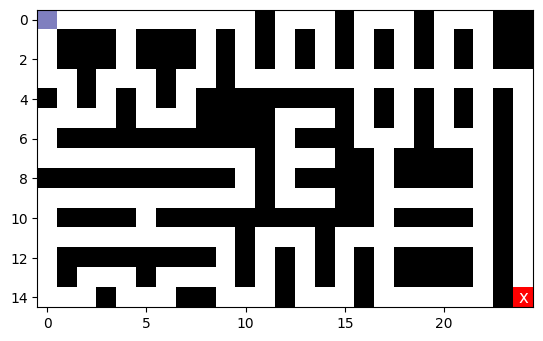

Possible actions ['down', 'right']
Action taken: down


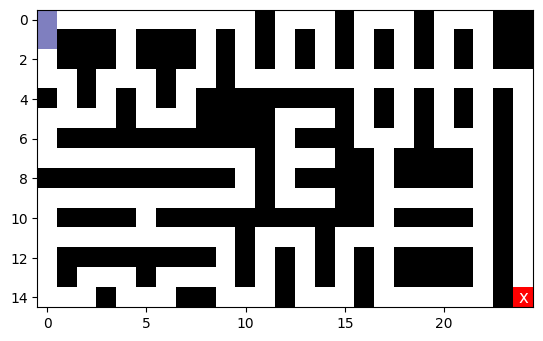

Possible actions ['up', 'down']
Action taken: down


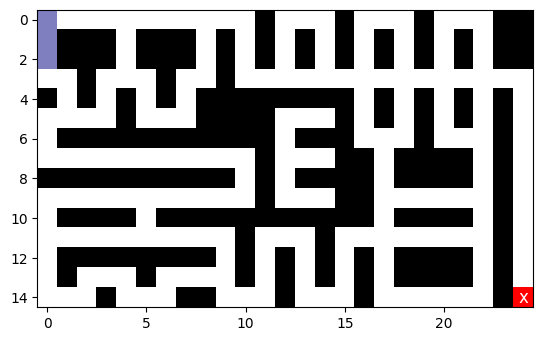

Possible actions ['up', 'down']
Action taken: down


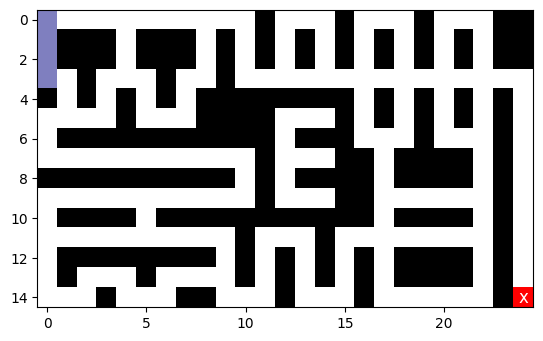

In [144]:
# Create a Maze instance.
maze = Maze("./../data/easy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)

# Track the coordinates of the agent to trace a path
# states = [(agent.get_state(maze).x, agent.get_state(maze).y)]
states = [(agent.get_state(maze).y, agent.get_state(maze).x)]
# Ensure our agent can move in the maze (Ensure we can take 10 valid steps)
print("Initial maze w/ agent")
maze.visualize(states)
for i in range(3):
    possible_actions = agent.get_valid_actions(maze)
    print("Possible actions", [x.id for x in possible_actions])
    action = random.choice(possible_actions)
    agent.step(action, maze)
    states.append((agent.get_state(maze).y, agent.get_state(maze).x))
    print("Action taken:", action.id)
    maze.visualize(states)

In [145]:
class ExplorationStrategy:
    def __init__(self, q_table: QTable):
        self.q_table = q_table

    def random(self, agent: Agent, maze: Maze):
        """
        The random exploration strategy selects a random action uniformly at random
        from the set of all valid actions.
        """
        actions = agent.get_valid_actions(maze)
        return random.choice(actions)

    def e_greedy(self, agent: Agent,  maze: Maze, eps: float = 0.1):
        """
        The e-greedy exploration strategy selects a random action with probability eps,
        and the action with highest q-value with probability 1 - eps. A value of epsilon
        close to 0 favours exploitation, while a value close to 1 favours exploration.
        """
        actions = agent.get_valid_actions(maze)
        if random.random() < eps:
            return random.choice(actions)
        else:
            q_values = [self.q_table.get_q(agent.get_state(maze), action) for action in actions]
            max_q_value = max(q_values)
            best_actions = [actions[i] for i in range(len(actions)) if q_values[i] == max_q_value]
            return random.choice(best_actions)

    def boltzmann(self, agent: Agent, maze: Maze, temperature: float = 0.1):
        """
        The Boltzmann exploration strategy assigns a probability to each action based on its estimated q-values.
        A large value of the temperature encourages exploration, and as the temperature declines over time,
        exploitation is favoured. 
        """
        actions = agent.get_valid_actions(maze)
        
        # Numerator of the equation
        q_values = np.array([self.q_table.get_q(agent.get_state(maze), action) for action in actions])
        exp_q_values = np.exp(q_values / temperature) 
        
        probabilities = exp_q_values / np.sum(exp_q_values)
        
        return random.choices(actions, weights=probabilities, k=1)[0] # k=1 returns a list, so we take the first element


<div style="background-color:#f1be3e">

Discussion of Implementation:
1. Random: We get the list of possible actions to take at this state and then pick a random possible action from this list.
2. E_Greedy: We use a random number generator that outputs values in [0,1) with equal chance. If this number is below epsilon (which has a probability of epsilon of happening), we select a possible action randomly with uniform distribution. Otherwise, we action that gives us the highest value
3. Boltzmann: We compute the probabilities of each possible action using the formula provided in the 2nd page of the lab manual, and then select a single action using this new distribution.

Strategy to prevent initial bias:
There may be times where there is no one, single best value or action to take. This could, for instance, happen at the start. To solve this, we introduce a tiebreaker by gathering the actions that provide the best value and selecting an action randomly from this group. 

Initial values:
Both hyperparameters, temperature and epsilon, were set to 0.1. This is just an initial guess that will be improved through hyperparameter tuning later.

#### Question 2

In [146]:
# Create a Maze instance.
maze = Maze("./../data/easy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
# learner = QLearning(q_table, params)

# Hyper-parameters.
n_episodes = 300
episode_lengths = []
episode_rewards = []

for episode in tqdm(range(n_episodes)):
    agent.reset()
    total_reward = 0
    done = False
    
    while not done:
        # action = exploration_strategy.random(agent, maze)
        action = exploration_strategy.e_greedy(agent, maze, eps=0.1)
        next_state, reward, done = agent.step(action, maze)
        # INSERT LEARNING HERE
        total_reward += reward
        
    episode_rewards.append(total_reward)
    episode_lengths.append(agent.nr_of_actions_since_reset)
    

100%|██████████| 300/300 [00:05<00:00, 59.85it/s]


<div style="background-color:#f1be3e">

For each episode:
1. Get an action to take next using an exploration strategy. This could be random, epsilon greedy, or Boltzmann.
2. Perform the action and get the new state and reward. 
3. Perform learning.
4. Update our total reward.
5. Check if we've reached a terminal state. If not, repeat from step 1.

This encapsulates all the steps that need to be taken, as through this, agents are already able to move through the maze and through learning, get better at finding the goal and reduce the amount of steps taken 

#### Question 3

In [147]:
# Create a Maze instance.
maze = Maze("./../data/easy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
#learner = QLearning(q_table, params)

# Hyper-parameters.
n_episodes = 300
episode_lengths = []
episode_rewards = []

for episode in tqdm(range(n_episodes)):
    agent.reset()
    total_reward = 0
    done = False
    while not done and agent.nr_of_actions_since_reset < 30000:
        action = exploration_strategy.e_greedy(agent, maze, eps=0.1)
        next_state, reward, done = agent.step(action, maze)
        total_reward += reward
    episode_rewards.append(total_reward)
    episode_lengths.append(agent.nr_of_actions_since_reset)
    
assert max(episode_lengths) <= 30000, "The agent stops correctly based on the stop criterion."
assert min(episode_lengths) < 30000

print("The maximum number of steps is", max(episode_lengths)," The minimum number of steps is", min(episode_lengths))

100%|██████████| 300/300 [00:05<00:00, 57.78it/s]

The maximum number of steps is 30000  The minimum number of steps is 278


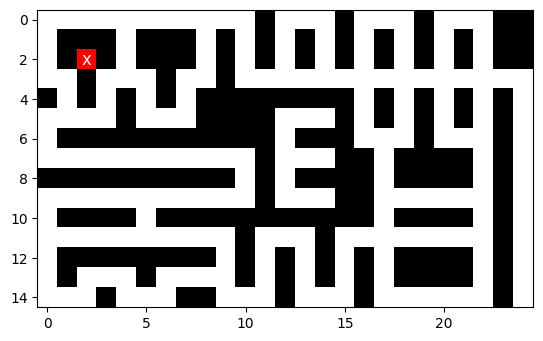

In [148]:
# Create a Maze instance where the goal is unreachable.
maze = Maze("./../data/easy_maze.txt")
maze.set_reward(x=2, y=2, reward=10)
maze.set_terminal(x=2, y=2)
maze.visualize([])

In [149]:
# Hyper-parameters.
n_episodes = 300
episode_lengths = []
episode_rewards = []

for episode in tqdm(range(n_episodes)):
    agent.reset()
    total_reward = 0
    done = False
    while not done and agent.nr_of_actions_since_reset < 30000:
        action = exploration_strategy.e_greedy(agent, maze, eps=0.1)
        next_state, reward, done = agent.step(action, maze)
        total_reward += reward
    episode_rewards.append(total_reward)
    episode_lengths.append(agent.nr_of_actions_since_reset)
    
for x in episode_lengths:
    assert x == 30000, "The agent stops correctly based on the stop criterion."
    
print("All the episodes in the maze with an unreachable terminal state are of length 30000")

100%|██████████| 300/300 [00:21<00:00, 13.69it/s]

All the episodes in the maze with an unreachable terminal state are of length 30000


<div style="background-color:#f1be3e">

We assert this behavior by:
1. Running on a maze with a reachable terminal state
2. Running on a maze with an unreachable terminal state

We verify that all the episodes have lengths of less than or equal to 30000. We also want to make sure that episodes are able to terminate earlier if a terminal state is reached, so we provide an extra assertion that the minimum of the paths should not take 30000 steps, just to verify this behavior.

To ensure that we truly are stopping at 30000 steps even if we don't reach a terminal state, we assert that all the episode lengths when our maze has unreachable terminal states are 30000.

#### Question 4

In [150]:
def avg_episode_lengths_10_runs(n_episodes: int, maze: Maze, agent: Agent, exploration_strategy: ExplorationStrategy, eps=0.1, temperature=0.1) -> float:
    episode_lengths_list = []
    for _ in tqdm(range(10)):
        episode_lengths = []
        for episode in range(n_episodes):
            agent.reset()
            done = False
            while not done and agent.nr_of_actions_since_reset < 30000:
                # action = exploration_strategy.random(agent, maze)
                action = exploration_strategy.e_greedy(agent, maze, eps)
                # action = exploration_strategy.boltzmann(agent, maze, temperature)
                next_state, reward, done = agent.step(action, maze)
            episode_lengths.append(agent.nr_of_actions_since_reset)
        episode_lengths_list.append(episode_lengths)
    return np.array(episode_lengths_list).mean(axis=0)

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


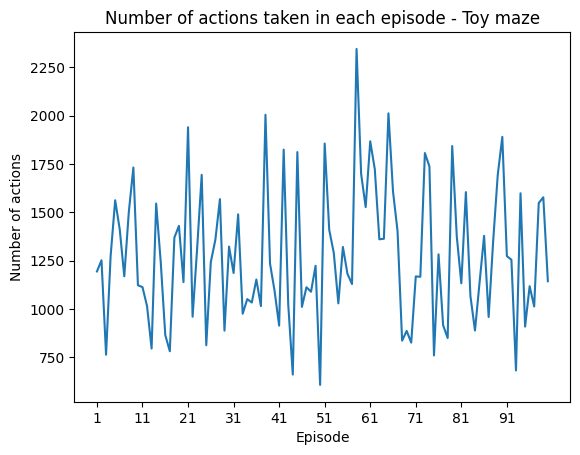

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


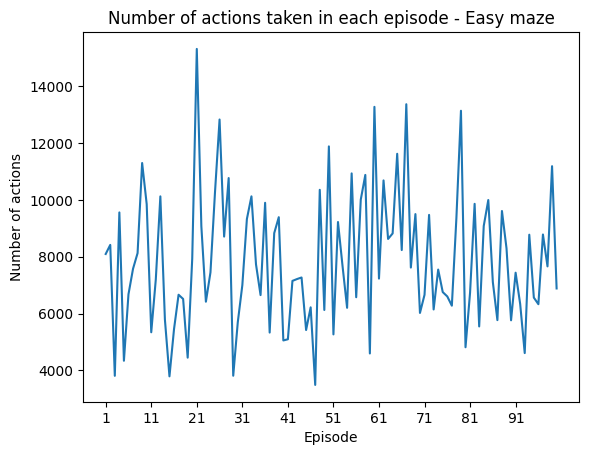

In [151]:
# Create a Maze instance.
toy_maze = Maze("./../data/toy_maze.txt")
toy_maze.set_reward(x=toy_maze.width-1, y=toy_maze.height-1, reward=10)
toy_maze.set_terminal(x=toy_maze.width-1, y=toy_maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = toy_maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
#learner = QLearning(q_table, params)

# Hyper-parameters.
n_episodes = 100

avg_toy_episode_lengths = avg_episode_lengths_10_runs(n_episodes, toy_maze, agent, exploration_strategy)

plt.plot(range(1, n_episodes + 1), avg_toy_episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Number of actions")
plt.title("Number of actions taken in each episode - Toy maze")

plt.xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))
plt.show()


# Create a Maze instance.
easy_maze = Maze("./../data/easy_maze.txt")
easy_maze.set_reward(x=easy_maze.width-1, y=easy_maze.height-1, reward=10)
easy_maze.set_terminal(x=easy_maze.width-1, y=easy_maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = easy_maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy = ExplorationStrategy(q_table)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
#learner = QLearning(q_table, params)

# Hyper-parameters.
n_episodes = 100

avg_easy_episode_lengths = avg_episode_lengths_10_runs(n_episodes, easy_maze, agent, exploration_strategy)

plt.plot(range(1, n_episodes + 1), avg_easy_episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Number of actions")
plt.title("Number of actions taken in each episode - Easy maze")

plt.xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))
plt.show()

<div style="background-color:#f1be3e">

From the plots' volatility, we see that an episode could have significantly more actions than the previous episode, and then much fewer actions than the next episode. This, coupled with the fact that the plot does not show a decreasing trend shows that the agent indeed does not learn.

#### Question 5

In [152]:
class QLearning:

    def __init__(self, q_table: QTable, params: Dict[str, float] = {"lr":0.7, "gamma":0.9}) -> None:
        self.q_table = q_table
        self.params = params

    def learn(self, possible_actions: List[Action], state: State, action: Action,
               next_state: State, reward: int, done: bool) -> None:
        # Get current Q-value for the state-action pair
        current_q_value = self.q_table.get_q(state, action)

        # Calculate the maximum Q-value for the next state
        next_q_values = [self.q_table.get_q(next_state, a) for a in possible_actions]

        # If there are no possible actions, set the maximum Q-value to 0
        max_next_q_value = max(next_q_values) if next_q_values else 0

        # Calculate the target Q-value using the Q-learning update rule
        target_q_value = reward + (not done)*(self.params["gamma"] * max_next_q_value)

        # Update Q-value using the Q-learning update rule
        new_q_value = current_q_value + self.params["lr"] * (target_q_value - current_q_value)

        # Update Q-value in the Q-table
        self.q_table.set_q(state, action, new_q_value)

In [153]:
class SARSA:

    def __init__(self, q_table: QTable, params: Dict[str, float] = {"lr":0.7, "gamma":0.9}) -> None:
        self.q_table = q_table
        self.params = params
    
    def learn(self, state: State, action: Action, next_state: State, next_action: Action,
               reward: float, done: bool) -> None:
        
        # Get current Q-value for the state-action pair
        current_q_value = self.q_table.get_q(state, action)

        # Calculate the Q-value for the next state-action pair
        next_q_value = self.q_table.get_q(next_state, next_action)
    
        # Calculate the target Q-value using the SARSA update rule
        target_q_value = reward + (not done) * self.params["gamma"] * next_q_value

        # Update Q-value using the SARSA update rule
        new_q_value = current_q_value + self.params["lr"] * (target_q_value - current_q_value)

        # Update Q-value in the Q-table
        self.q_table.set_q(state, action, new_q_value)

<div style="background-color:#f1be3e">

#### SARSA
In SARSA learning, we learn the value of the policy being carried out by the agent and hope that through further exploration, we ultimately find and converge to the best policy. Our implementation uses the temporal difference version of the update equation:

$$Q(s,a) \leftarrow Q(s,a) + \alpha(r + \gamma \times Q(s',a') - Q(s,a)) $$

$Q$ is our q-table, $s$ the current state, $a$ the previous action taken, $a'$ and $s'$ the chosen action and future state, respectively, $\alpha$ the learning rate, and $\gamma$ the discount factor  

#### Q-Learning
In Q-learning, we perform updates irrespective of the selected action, and instead update based on the optimal policy. Our implementation once again uses the temporal difference version of the update equation:

$$Q(s,a) \leftarrow Q(s,a) + \alpha(r + \gamma \times max_b[Q(s',b)] - Q(s,a)) $$

$Q$ is our q-table, $s$ the current state, $a$ the previous action taken, $a'$ and $s'$ the chosen action and future state, respectively, $\alpha$ the learning rate, and $\gamma$ the discount factor  

A note on terminal states:
As the formulas depend on the next state, once a terminal state is reached, we do not have a future state to apply to our formula. To counteract this, we utilize the 'done' variable to decide whether to include the future state term in our equation.

#### Question 6

In [154]:
def avg_episode_lengths_10_runs_QLearning(n_episodes: int, maze: Maze, agent: Agent, exploration_strategy: ExplorationStrategy, learner: QLearning, eps=0.1, temperature=0.1) -> float:
    episode_lengths_list = []
    episode_rewards_list = []
    for _ in range(10):
        episode_lengths = []
        episode_rewards = []
        for episode in range(n_episodes):
            agent.reset()
            total_reward = 0
            done = False
            while not done and agent.nr_of_actions_since_reset < 30000:
                # action = exploration_strategy.random(agent, maze)
                action = exploration_strategy.e_greedy(agent, maze, eps)
                # action = exploration_strategy.boltzmann(agent, maze, temperature)
                current_state = agent.get_state(maze)
                next_state, reward, done = agent.step(action, maze)
                learner.learn(agent.get_valid_actions(maze), current_state, action, next_state, reward, done)
                total_reward += reward
            episode_rewards.append(total_reward)
            episode_lengths.append(agent.nr_of_actions_since_reset)
        episode_lengths_list.append(episode_lengths)
        episode_rewards_list.append(episode_rewards)
    return np.array(episode_lengths_list).mean(axis=0), np.array(episode_rewards_list).mean(axis=0)

In [155]:
def avg_episode_lengths_10_runs_SARSA(n_episodes: int, maze: Maze, agent: Agent, exploration_strategy: ExplorationStrategy, learner: SARSA, eps=0.1, temperature=0.1) -> float:
    episode_lengths_list = []
    episode_rewards_list = []
    for _ in range(10):
        episode_lengths = []
        episode_rewards = []
        for episode in range(n_episodes):
            agent.reset()
            total_reward = 0
            next_action = exploration_strategy.e_greedy(agent, maze, eps)
            done = False
            while not done and agent.nr_of_actions_since_reset < 30000:
                # action = exploration_strategy.random(agent, maze)
                action = next_action
                # action = exploration_strategy.boltzmann(agent, maze, temperature)
                current_state = agent.get_state(maze)
                next_state, reward, done = agent.step(action, maze)
                # next_action = exploration_strategy.random(agent, maze)
                next_action = exploration_strategy.e_greedy(agent, maze, eps)
                learner.learn(current_state, action, next_state, next_action, reward, done)
                total_reward += reward
            episode_lengths.append(agent.nr_of_actions_since_reset)
            episode_rewards.append(total_reward)
        episode_lengths_list.append(episode_lengths)
        episode_rewards_list.append(episode_rewards)
    return np.array(episode_lengths_list).mean(axis=0), np.array(episode_rewards_list).mean(axis=0)

In [181]:
# Q-Learning - Toy maze
# Create a Maze instance
maze = Maze("./../data/toy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table_QLearning = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
QLearning_learner = QLearning(q_table_QLearning, params)
# Hyper-parameters.
n_episodes = 500
avg_episode_lengths_QLearning_toy, avg_episode_rewards_QLearning_toy = avg_episode_lengths_10_runs_QLearning(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner)

# SARSA - Toy maze
maze = Maze("./../data/toy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)

states = maze.get_all_states()
q_table_SARSA = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy_SARSA = ExplorationStrategy(q_table_SARSA)

SARSA_learner = SARSA(q_table_SARSA, params)

avg_episode_lengths_SARSA_toy, avg_episode_rewards_SARSA_toy = avg_episode_lengths_10_runs_SARSA(n_episodes, maze, agent, exploration_strategy_SARSA, SARSA_learner)

# Q-Learning - Easy maze
# Create a Maze instance
maze = Maze("./../data/easy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
# Create a QTable.
states = maze.get_all_states()
actions = [Action(id) for id in ["up", "down", "left", "right"]]
q_table_QLearning = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
# Create a learner.
params = {"lr": 0.7, "gamma": 0.9}
QLearning_learner = QLearning(q_table_QLearning, params)
# Hyper-parameters.
n_episodes = 500
avg_episode_lengths_QLearning_easy, avg_episode_rewards_QLearning_easy = avg_episode_lengths_10_runs_QLearning(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner)

# SARSA - Easy maze
maze = Maze("./../data/easy_maze.txt")
maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
maze.set_terminal(x=maze.width-1, y=maze.height-1)

states = maze.get_all_states()
q_table_SARSA = QTable(states, actions)
# Create an ExplorationStrategy.
exploration_strategy_SARSA = ExplorationStrategy(q_table_SARSA)

SARSA_learner = SARSA(q_table_SARSA, params)

avg_episode_lengths_SARSA_easy, avg_episode_rewards_SARSA_easy = avg_episode_lengths_10_runs_SARSA(n_episodes, maze, agent, exploration_strategy_SARSA, SARSA_learner)

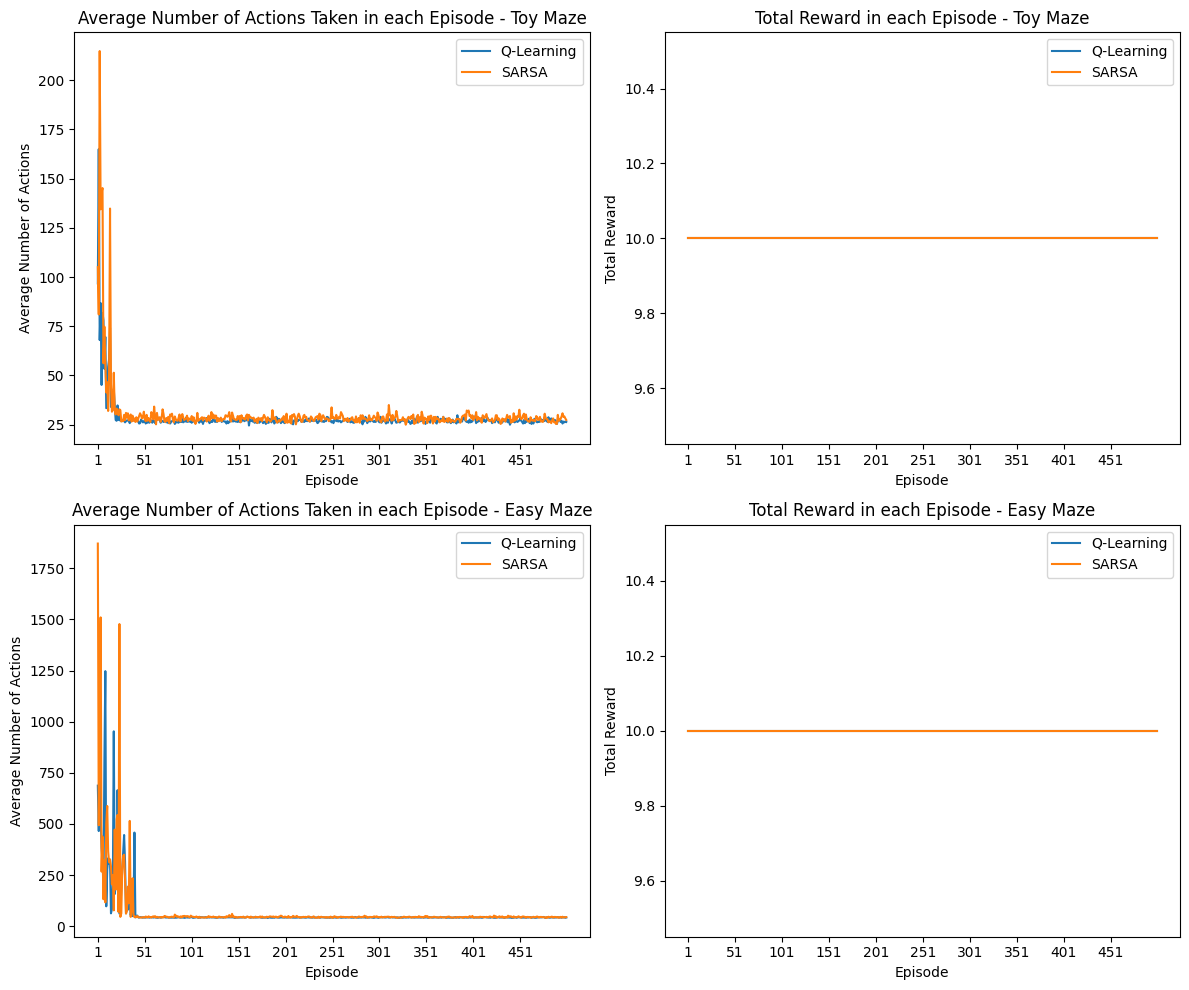

In [182]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot episode lengths - Toy Maze
axs[0][0].plot(range(1, n_episodes + 1), avg_episode_lengths_QLearning_toy, label='Q-Learning')
axs[0][0].plot(range(1, n_episodes + 1), avg_episode_lengths_SARSA_toy, label='SARSA')
axs[0][0].set_xlabel("Episode")
axs[0][0].set_ylabel("Average Number of Actions")
axs[0][0].set_title("Average Number of Actions Taken in each Episode - Toy Maze")
axs[0][0].legend()
axs[0][0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Plot total reward - Toy Maze
axs[0][1].plot(range(1, n_episodes + 1), avg_episode_rewards_QLearning_toy, label='Q-Learning')
axs[0][1].plot(range(1, n_episodes + 1), avg_episode_rewards_SARSA_toy, label='SARSA')
axs[0][1].set_xlabel("Episode")
axs[0][1].set_ylabel("Total Reward")
axs[0][1].set_title("Total Reward in each Episode - Toy Maze")
axs[0][1].legend()
axs[0][1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Plot episode lengths - Easy Maze
axs[1][0].plot(range(1, n_episodes + 1), avg_episode_lengths_QLearning_easy, label='Q-Learning')
axs[1][0].plot(range(1, n_episodes + 1), avg_episode_lengths_SARSA_easy, label='SARSA')
axs[1][0].set_xlabel("Episode")
axs[1][0].set_ylabel("Average Number of Actions")
axs[1][0].set_title("Average Number of Actions Taken in each Episode - Easy Maze")
axs[1][0].legend()
axs[1][0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Plot total reward - Easy Maze
axs[1][1].plot(range(1, n_episodes + 1), avg_episode_rewards_QLearning_easy, label='Q-Learning')
axs[1][1].plot(range(1, n_episodes + 1), avg_episode_rewards_SARSA_easy, label='SARSA')
axs[1][1].set_xlabel("Episode")
axs[1][1].set_ylabel("Total Reward")
axs[1][1].set_title("Total Reward in each Episode - Easy Maze")
axs[1][1].legend()
axs[1][1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Adjust layout
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

#### Plot rationale:
For each maze, we plot:
1. The average number of actions. This ensures that we are getting better at finding the shortest route over episodes.
2. The total reward in each episode. We want to ensure that we are reaching the goal.

Note: we are indeed running our agent with one learning algorithm at a time. For easier comparison in the subsequent question, we have decided to plot the results of both algorithms on one graph.

#### Discussion:
The plots above show a downward trend in the long run for number of actions taken in each episode. This is true for both the easy maze and toy maze. The downward trend seems to indicate that our agent is indeed learning and getting better at finding the shortest path in both mazes. It is, however, important to note that the number of actions is not strictly decreasing. Instead, 3 consecutive episodes could show an upward trend before going back down. This displays the uncertain nature of each consecutive episode, even though looking at the graph in its entirety shows a convergence to a smaller number of actions. Even after the number of actions seems to converge, small spikes are evident as we are using epsilon-greedy to select actions, which might choose a suboptimal path that deviates from our established q-table optimum.

#### Question 7

<div style="background-color:#f1be3e">

Although both methods seem to ultimately converge to similar number of actions per episode, one big difference is in the shape of the graphs. Q-learning seems to be more stable, with smaller fluctuations than SARSA. This is most likely because we are always updating our optimal policy in Q-Learning (the max term in our equation). In the case of SARSA, we update the q-values for the next action. This means our policies could end up changing significantly with the SARSA algorithm with each episode, which leads to this observed behavior

### 2.2 Optimization
#### Question 8

In [158]:
def avg_episode_lengths_10_runs_QLearning_epsilon_greedy(n_episodes: int, maze: Maze, agent: Agent, exploration_strategy: ExplorationStrategy, learner: QLearning, eps=0.1, temperature=0.1) -> float:
    episode_lengths_list = []
    episode_rewards_list = []
    for _ in tqdm(range(10)):
        episode_lengths = []
        episode_rewards = []
        for episode in range(n_episodes):
            agent.reset()
            total_reward = 0
            done = False
            while not done and agent.nr_of_actions_since_reset < 30000:
                # action = exploration_strategy.random(agent, maze)
                action = exploration_strategy.e_greedy(agent, maze, eps)
                # action = exploration_strategy.boltzmann(agent, maze, temperature)
                current_state = agent.get_state(maze)
                next_state, reward, done = agent.step(action, maze)
                learner.learn(agent.get_valid_actions(maze), current_state, action, next_state, reward, done)
                total_reward += reward
            episode_rewards.append(total_reward)
            episode_lengths.append(agent.nr_of_actions_since_reset)
        episode_lengths_list.append(episode_lengths)
        episode_rewards_list.append(episode_rewards)
    return np.array(episode_lengths_list).mean(axis=0), np.array(episode_rewards_list).mean(axis=0)

In [159]:
def avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy(n_episodes: int, agent: Agent, eps, temperature, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_QLearning = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    QLearning_learner = QLearning(q_table_QLearning, params)

    return avg_episode_lengths_10_runs_QLearning_epsilon_greedy(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner, eps=eps, temperature=temperature)

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


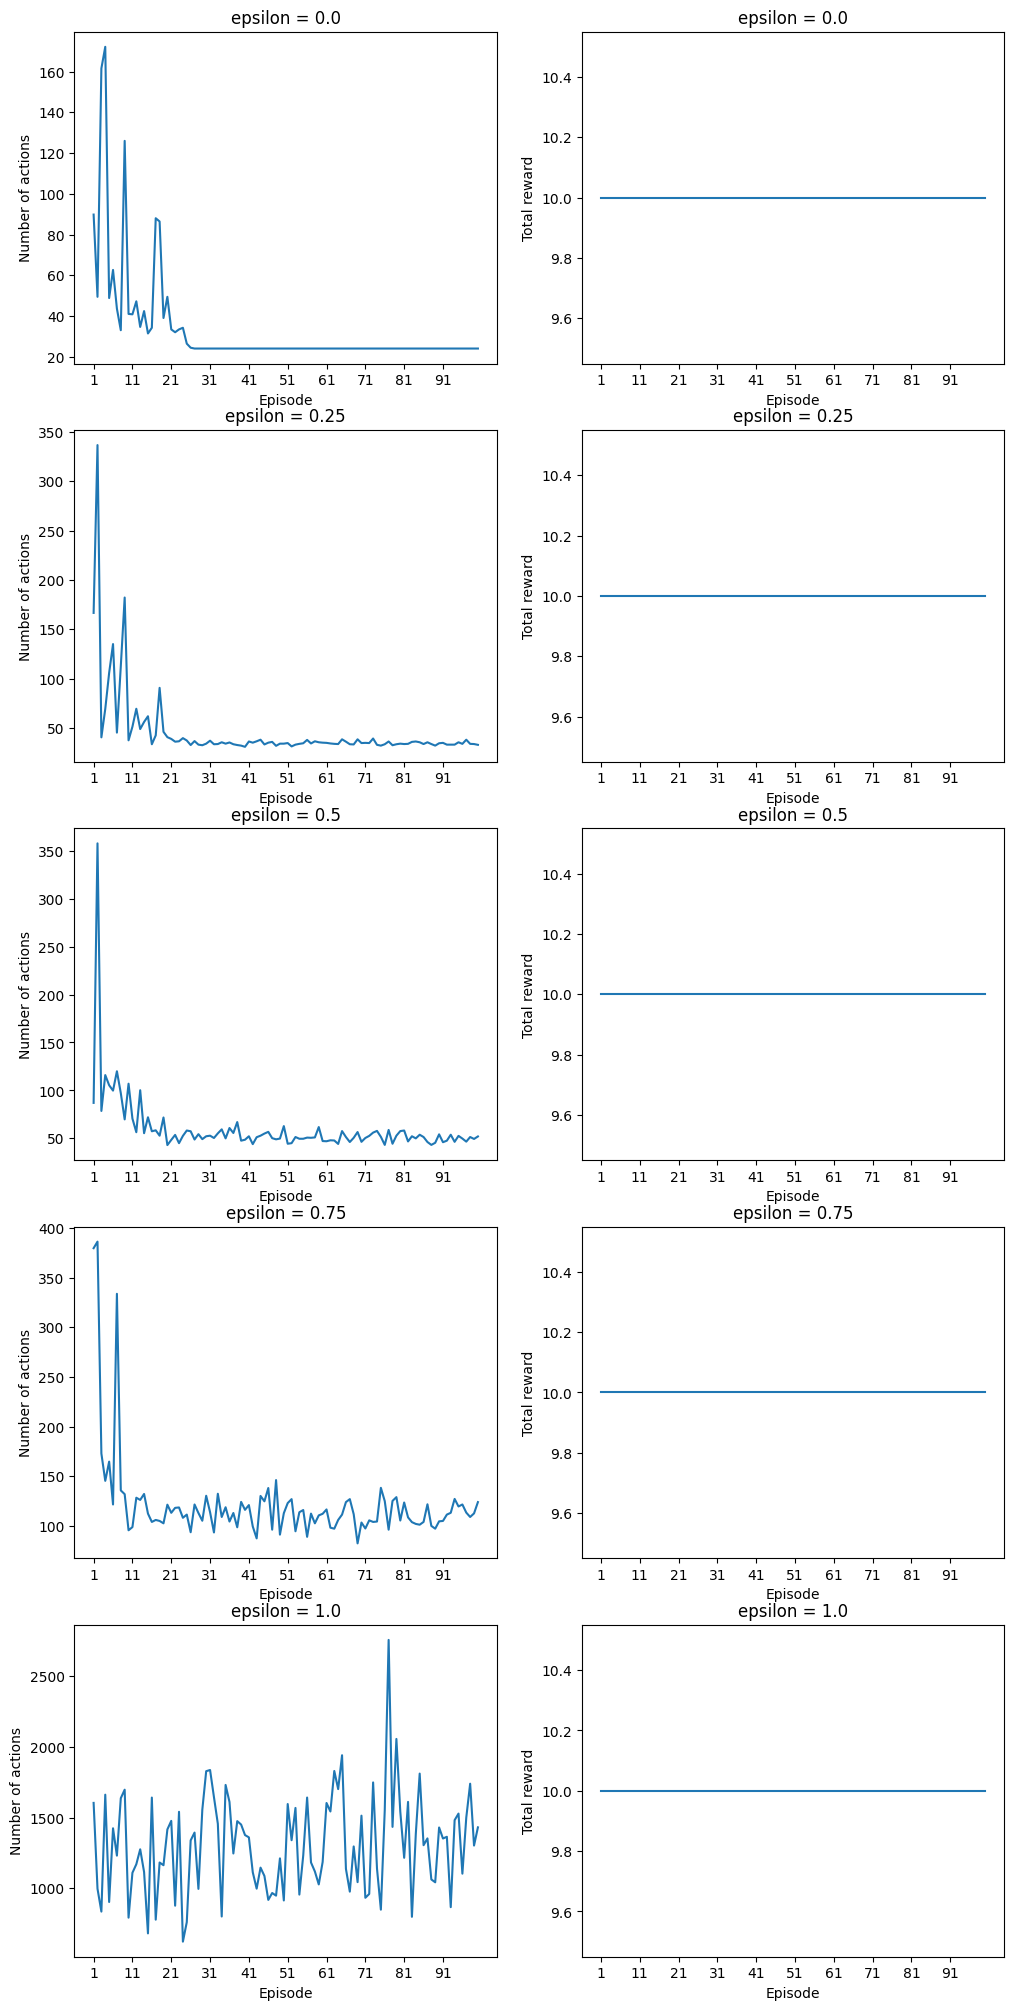

In [160]:
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
epsilon_values = [0.0, 0.25, 0.5, 0.75, 1.0]
fig, axs = plt.subplots(5, 2, figsize=(12, 25))
n_episodes = 100
for i, eps in enumerate(epsilon_values):
    avg_episode_lengths, avg_episode_rewards = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy(n_episodes, agent, eps, 0.1)
    axs[i, 0].plot(range(1, n_episodes + 1), avg_episode_lengths)
    axs[i, 0].set_title(f"epsilon = {eps}")
    axs[i, 0].set_xlabel("Episode")
    axs[i, 0].set_ylabel("Number of actions")
    axs[i, 0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

    axs[i, 1].plot(range(1, n_episodes + 1), avg_episode_rewards)
    axs[i, 1].set_title(f"epsilon = {eps}")
    axs[i, 1].set_xlabel("Episode")
    axs[i, 1].set_ylabel("Total reward")
    axs[i, 1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

<div style="background-color:#f1be3e">

#### Discussion
The plots seem to get increasingly more volatile the higher epsilon is. The smallest number of actions is achieved with an epsilon value of 0, suggesting that for our toy maze, the best value of epsilon to use is 0, where no exploration is done.

#### Explanation
This is most likely because there are not a lot of paths that lead from the start of the maze to the end, and thus there is little need for exploration. This could then explain why increasing epsilon only serves to make our results worse.

#### Question 9

<div style="background-color:#f1be3e">

A high e allows for more exploration than exploitation, which is useful if multiple paths exist and need to be explored. Otherwise, using e=0 might get the agent stuck on a local minima. However, a value that is too high puts this at risk of adding too much randomness so that we never converge to an optimum. This means, for large, complex mazes, we need to find a balance for this value that allows for the right balance between exploitation (running through the current found optimal path) and exploration (running through a random path in hopes that it will be better than our current optimal)

#### Question 10

In [161]:
def avg_episode_lengths_10_runs_boltzmann(n_episodes: int, maze: Maze, agent: Agent, exploration_strategy: ExplorationStrategy, learner: QLearning, eps=0.1, temperature=0.1) -> float:
    episode_lengths_list = []
    episode_rewards_list = []
    for _ in range(10):
        episode_lengths = []
        episode_rewards = []
        for episode in range(n_episodes):
            agent.reset()
            total_reward = 0
            done = False
            while not done and agent.nr_of_actions_since_reset < 30000:
                # action = exploration_strategy.random(agent, maze)
                # action = exploration_strategy.e_greedy(agent, maze, eps)
                action = exploration_strategy.boltzmann(agent, maze, temperature)
                current_state = agent.get_state(maze)
                next_state, reward, done = agent.step(action, maze)
                learner.learn(agent.get_valid_actions(maze), current_state, action, next_state, reward, done)
                total_reward += reward
            episode_rewards.append(total_reward)
            episode_lengths.append(agent.nr_of_actions_since_reset)
        episode_lengths_list.append(episode_lengths)
        episode_rewards_list.append(episode_rewards)
    return np.array(episode_lengths_list).mean(axis=0), np.array(episode_rewards_list).mean(axis=0)

In [162]:
def avg_episode_lengths_10_runs_QLearning_toy_maze_boltzmann(n_episodes: int, agent: Agent, eps, temperature, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_QLearning = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    QLearning_learner = QLearning(q_table_QLearning, params)

    return avg_episode_lengths_10_runs_boltzmann(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner, eps=eps, temperature=temperature)


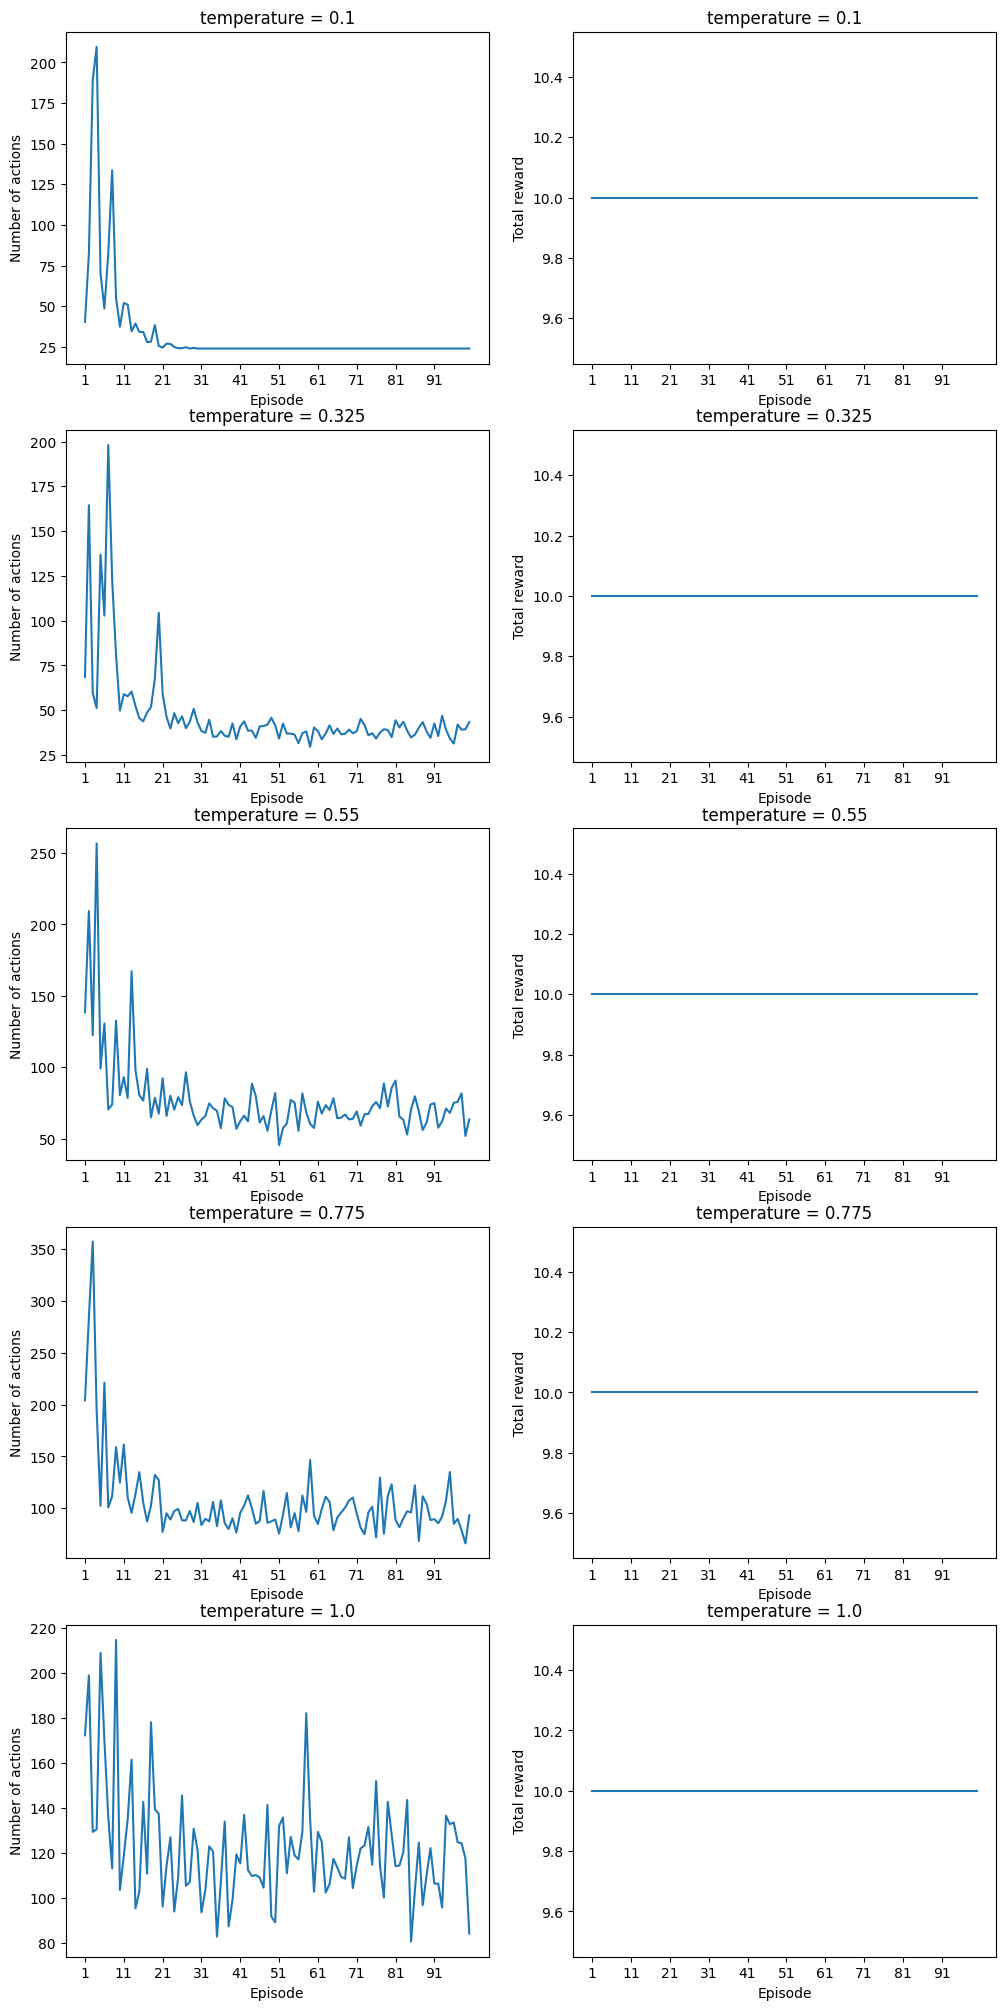

In [163]:
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
temperature_values = [0.1, 0.325, 0.55, 0.775, 1.0]
fig, axs = plt.subplots(5, 2, figsize=(12, 25))
n_episodes = 100
for i, temperature in enumerate(temperature_values):
    avg_episode_lengths, avg_episode_rewards = avg_episode_lengths_10_runs_QLearning_toy_maze_boltzmann(n_episodes, agent, 0.1, temperature)
    axs[i, 0].plot(range(1, n_episodes + 1), avg_episode_lengths)
    axs[i, 0].set_title(f"temperature = {temperature}")
    axs[i, 0].set_xlabel("Episode")
    axs[i, 0].set_ylabel("Number of actions")
    axs[i, 0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

    axs[i, 1].plot(range(1, n_episodes + 1), avg_episode_rewards)
    axs[i, 1].set_title(f"temperature = {temperature}")
    axs[i, 1].set_xlabel("Episode")
    axs[i, 1].set_ylabel("Total reward")
    axs[i, 1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

<div style="background-color:#f1be3e">

Like epsilon, the trade-off seems to be stability. A high T means more exploration is done by the agent, and a low T means more exploitation is done. Our maze is very simple, and thus it excels with a very low T, as little exploration is needed to be done. However, for a more complex maze, a high T is required to allow the agent to traverse through multiple paths in search of an optimal.

#### Question 11

<div style="background-color:#f1be3e">

Looking at our graphs, it seems that Boltzmann exploration is the better strategy. We have observed fewer number of episodes required in order to get to a stable optimum with this strategy than with epsilon-greedy. 

Boltzmann's advantage comes from the way it handles exploration. Epsilon-greedy uniformly selects from the list of available moves, which would not be ideal if in this list, 1 move is significantly better than the rest. By assigning weighted probabilities, the Boltzmann strategy allows us to select a more reasonable action during our exploration, allowing us to end up with better moves more often.

#### Question 12

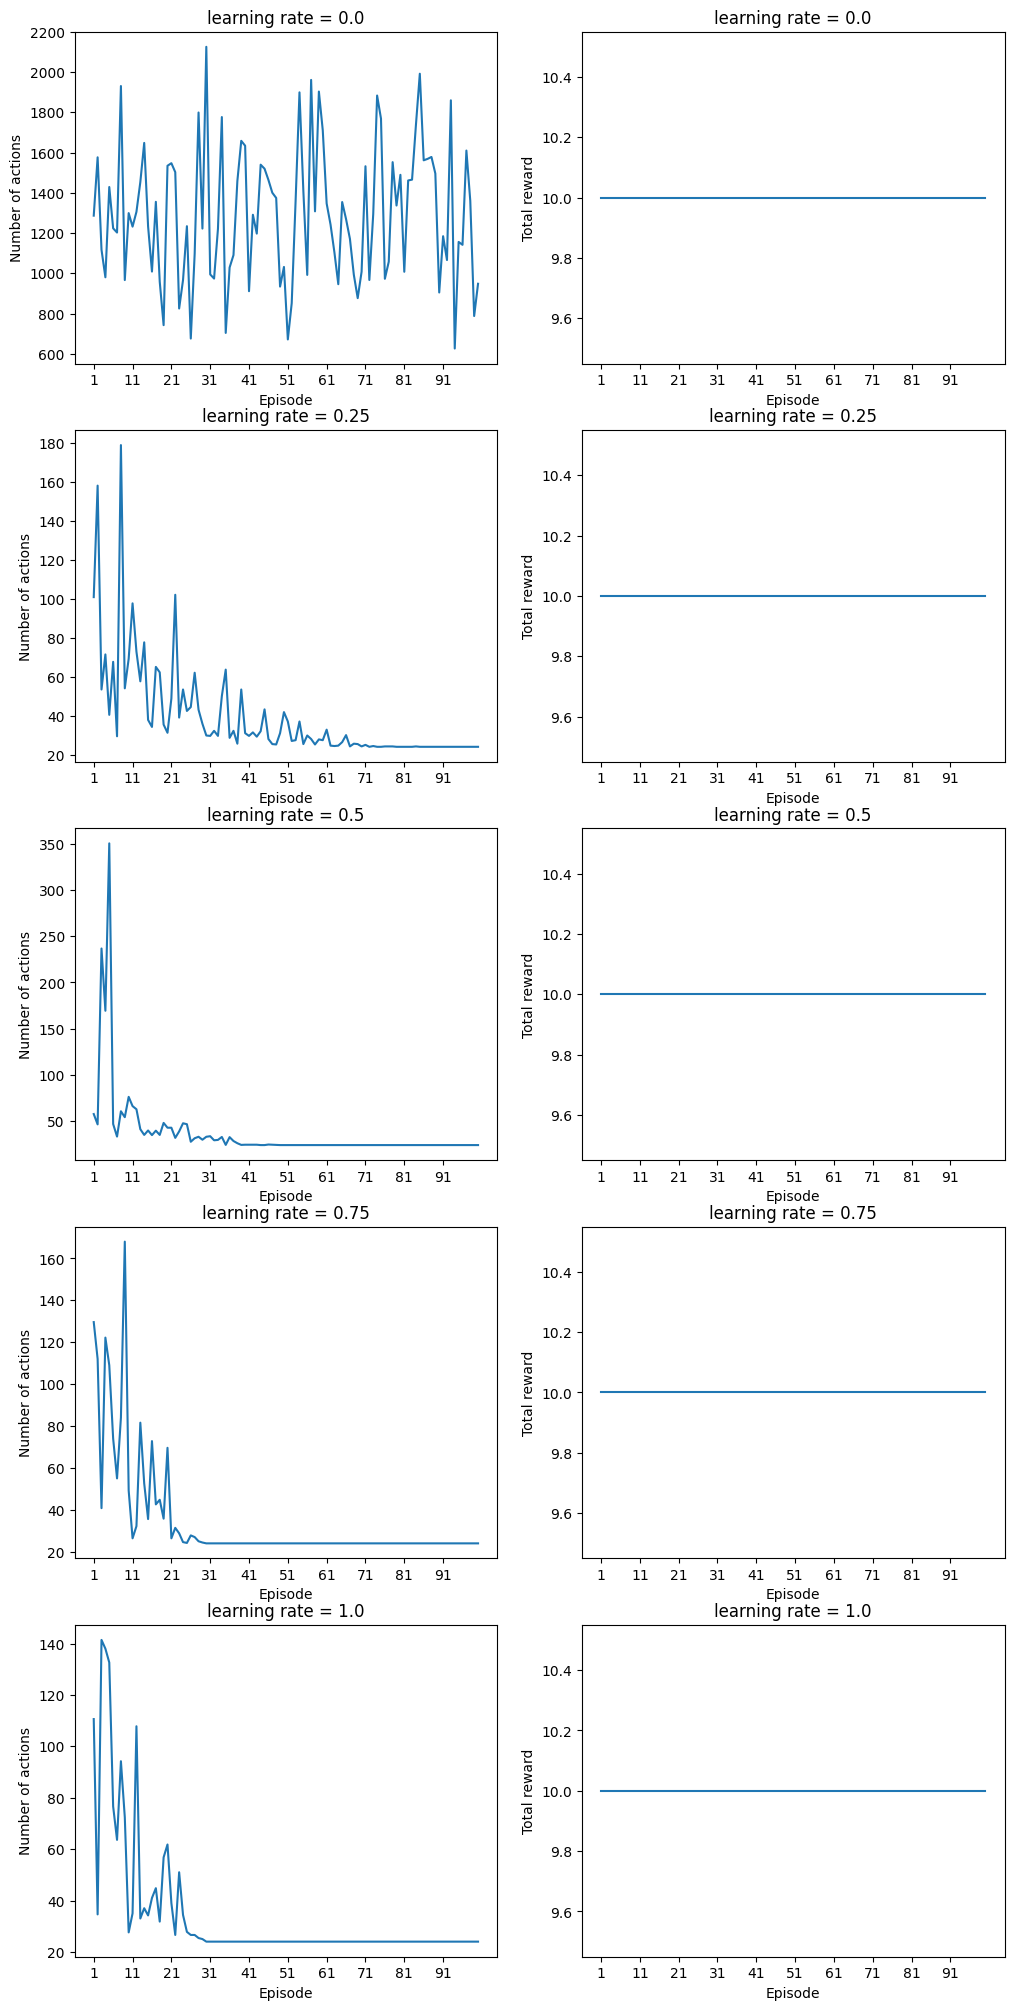

In [164]:
agent = Agent(start_x=0, start_y=0)
lr_values = [0.0, 0.25, 0.5, 0.75, 1.0]
fig, axs = plt.subplots(5, 2, figsize=(12, 25))
n_episodes = 100
for i, lr in enumerate(lr_values):
    avg_episode_lengths, avg_episode_rewards = avg_episode_lengths_10_runs_QLearning_toy_maze_boltzmann(n_episodes, agent, 0.1, 0.1, lr=lr)
    axs[i, 0].plot(range(1, n_episodes + 1), avg_episode_lengths)
    axs[i, 0].set_title(f"learning rate = {lr}")
    axs[i, 0].set_xlabel("Episode")
    axs[i, 0].set_ylabel("Number of actions")
    axs[i, 0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

    axs[i, 1].plot(range(1, n_episodes + 1), avg_episode_rewards)
    axs[i, 1].set_title(f"learning rate = {lr}")
    axs[i, 1].set_xlabel("Episode")
    axs[i, 1].set_ylabel("Total reward")
    axs[i, 1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

<div style="background-color:#f1be3e">

#### Discussion
Learning rate seems to greatly affect the speed of convergence. Through the graphs detailing the number of actions, we see a trend where the larger the learning rate is, the fewer number of episodes it takes until the number of actions converges. This is also true for total rewards. 

#### Explanation
$$Q(s,a) \leftarrow Q(s,a) + \alpha(r + \gamma \times max_b[Q(s',b)] - Q(s,a)) $$
Looking at the formula, we see that learning rate affects how big updates to the table are. A small learning rate means we are changing the q table in smaller increments, which makes means we will usually need more episodes in order to reach convergence than if we use large learning rates.

### 2.3 Introducing More Rewards
#### Question 13

In [165]:
def avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_2_terminals(n_episodes: int, agent: Agent, eps, temperature, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)

    maze.set_reward(x=maze.width-1, y=0, reward=5)
    maze.set_terminal(x=maze.width-1, y=0)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_QLearning = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    QLearning_learner = QLearning(q_table_QLearning, params)

    return avg_episode_lengths_10_runs_QLearning_epsilon_greedy(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner, eps=eps, temperature=temperature)

100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


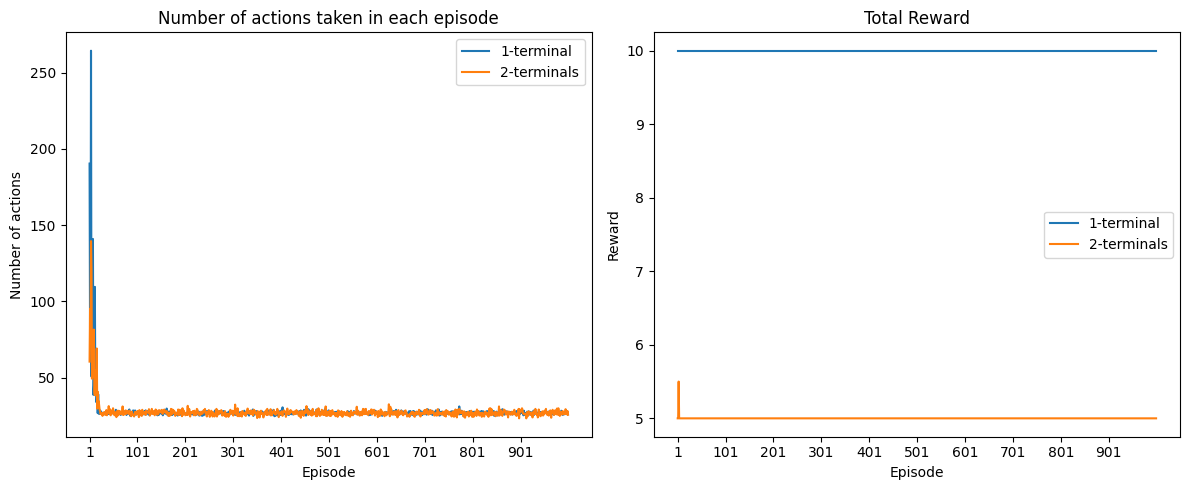

In [184]:
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
n_episodes = 1000
avg_episode_lengths_1_terminal, avg_episode_rewards_1_terminal = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy(n_episodes, agent, 0.1, 0.1)
avg_episode_lengths_2_terminals, avg_episode_rewards_2_terminals = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_2_terminals(n_episodes, agent, 0.2, 0.1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(range(1, n_episodes + 1), avg_episode_lengths_1_terminal, label='1-terminal')
axs[0].plot(range(1, n_episodes + 1), avg_episode_lengths_2_terminals, label='2-terminals')
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Number of actions")
axs[0].set_title("Number of actions taken in each episode")
axs[0].legend()
axs[0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Plot Q-Learning episode lengths
axs[1].plot(range(1, n_episodes + 1), avg_episode_rewards_1_terminal, label='1-terminal')
axs[1].plot(range(1, n_episodes + 1), avg_episode_rewards_2_terminals, label='2-terminals')
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Reward")
axs[1].set_title("Total Reward")
axs[1].legend()
axs[1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Adjust layout
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

The problem is that we are going to the smaller reward most of the time. This is due to Q-learning's update of the most optimal policy. As the smaller reward is closer to us, there is a high probability that we reach this reward first. As such, this is the policy that the agent tends to converge to.

#### Question 14

In [167]:
def avg_episode_lengths_10_runs_SARSA_toy_maze_epsilon_greedy(n_episodes: int, agent: Agent, eps, temperature, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_SARSA = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_SARSA = ExplorationStrategy(q_table_SARSA)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    SARSA_learner = SARSA(q_table_SARSA, params)

    return avg_episode_lengths_10_runs_SARSA(n_episodes, maze, agent, exploration_strategy_SARSA, SARSA_learner, eps=eps, temperature=temperature)

In [168]:
def avg_episode_lengths_10_runs_SARSA_toy_maze_epsilon_greedy_2_terminals(n_episodes: int, agent: Agent, eps, temperature, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)

    maze.set_reward(x=maze.width-1, y=0, reward=5)
    maze.set_terminal(x=maze.width-1, y=0)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_SARSA = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_SARSA = ExplorationStrategy(q_table_SARSA)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    SARSA_learner = SARSA(q_table_SARSA, params)

    return avg_episode_lengths_10_runs_SARSA(n_episodes, maze, agent, exploration_strategy_SARSA, SARSA_learner, eps=eps, temperature=temperature)

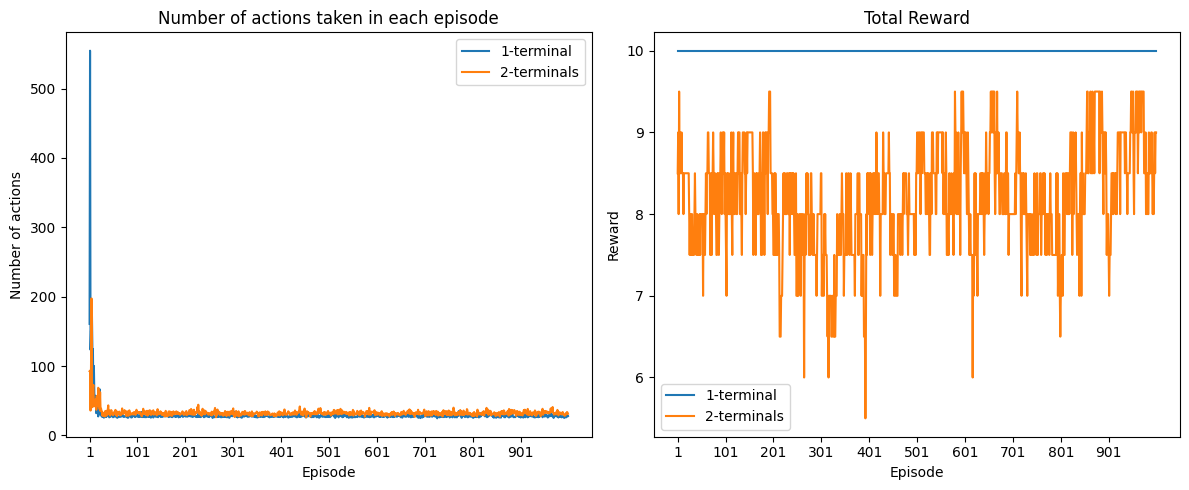

In [169]:
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
n_episodes = 1000
avg_episode_lengths_1_terminal, avg_episode_rewards_1_terminal = avg_episode_lengths_10_runs_SARSA_toy_maze_epsilon_greedy(n_episodes, agent, 0.1, 0.1)
avg_episode_lengths_2_terminals, avg_episode_rewards_2_terminals = avg_episode_lengths_10_runs_SARSA_toy_maze_epsilon_greedy_2_terminals(n_episodes, agent, 0.2, 0.1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(range(1, n_episodes + 1), avg_episode_lengths_1_terminal, label='1-terminal')
axs[0].plot(range(1, n_episodes + 1), avg_episode_lengths_2_terminals, label='2-terminals')
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Number of actions")
axs[0].set_title("Number of actions taken in each episode")
axs[0].legend()
axs[0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Plot Q-Learning episode lengths
axs[1].plot(range(1, n_episodes + 1), avg_episode_rewards_1_terminal, label='1-terminal')
axs[1].plot(range(1, n_episodes + 1), avg_episode_rewards_2_terminals, label='2-terminals')
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Reward")
axs[1].set_title("Total Reward")
axs[1].legend()
axs[1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Adjust layout
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

Switching to SARSA does help solve the problem above, as the learning method allows us to perform more exploration by updating the q table based on the current policy we have instead of the optimum. 

The problem with Q-learning is that once we find a path that reaches a goal, that becomes the optimal policy, and it tends to get stuck. This makes Q-learning more stable but more prone to finding local optima. 

SARSA, on the other hand, updates based on the action the agent has selected. This allows the agent to explore multiple paths that reach to different goals.

#### Question 15

In [170]:
def avg_episode_lengths_10_runs_QLearning_epsilon_greedy_decay(n_episodes: int, maze: Maze, agent: Agent, exploration_strategy: ExplorationStrategy, learner: QLearning, eps=1, temperature=0.1) -> float:
    episode_lengths_list = []
    episode_rewards_list = []
    decay = (eps - 0.01) / n_episodes
    for _ in range(10):
        episode_lengths = []
        episode_rewards = []
        for episode in range(n_episodes):
            agent.reset()
            total_reward = 0
            done = False
            epsilon = eps - decay * episode
            while not done and agent.nr_of_actions_since_reset < 30000:
                # action = exploration_strategy.random(agent, maze)
                action = exploration_strategy.e_greedy(agent, maze, epsilon)
                # action = exploration_strategy.boltzmann(agent, maze, temperature)
                current_state = agent.get_state(maze)
                next_state, reward, done = agent.step(action, maze)
                learner.learn(agent.get_valid_actions(maze), current_state, action, next_state, reward, done)
                total_reward += reward
            episode_rewards.append(total_reward)
            episode_lengths.append(agent.nr_of_actions_since_reset)
        episode_lengths_list.append(episode_lengths)
        episode_rewards_list.append(episode_rewards)
    return np.array(episode_lengths_list).mean(axis=0), np.array(episode_rewards_list).mean(axis=0)


In [171]:
def avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_decay(n_episodes: int, agent: Agent, eps=1.0, temperature=0.1, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_QLearning = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    QLearning_learner = QLearning(q_table_QLearning, params)

    return avg_episode_lengths_10_runs_QLearning_epsilon_greedy_decay(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner, eps=eps, temperature=temperature)

In [172]:
def avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_2_terminals_decay(n_episodes: int, agent: Agent, eps=1.0, temperature=0.1, lr=0.7, gamma=0.9) -> float:
    # Create a Maze instance.
    maze = Maze("./../data/toy_maze.txt")
    maze.set_reward(x=maze.width-1, y=maze.height-1, reward=10)
    maze.set_terminal(x=maze.width-1, y=maze.height-1)

    maze.set_reward(x=maze.width-1, y=0, reward=5)
    maze.set_terminal(x=maze.width-1, y=0)
    # Create a QTable.
    states = maze.get_all_states()
    actions = [Action(id) for id in ["up", "down", "left", "right"]]
    q_table_QLearning = QTable(states, actions)
    # Create an ExplorationStrategy.
    exploration_strategy_QLearning = ExplorationStrategy(q_table_QLearning)
    # Create a learner.
    params = {"lr": lr, "gamma": gamma}
    QLearning_learner = QLearning(q_table_QLearning, params)

    return avg_episode_lengths_10_runs_QLearning_epsilon_greedy_decay(n_episodes, maze, agent, exploration_strategy_QLearning, QLearning_learner, eps=eps, temperature=temperature)

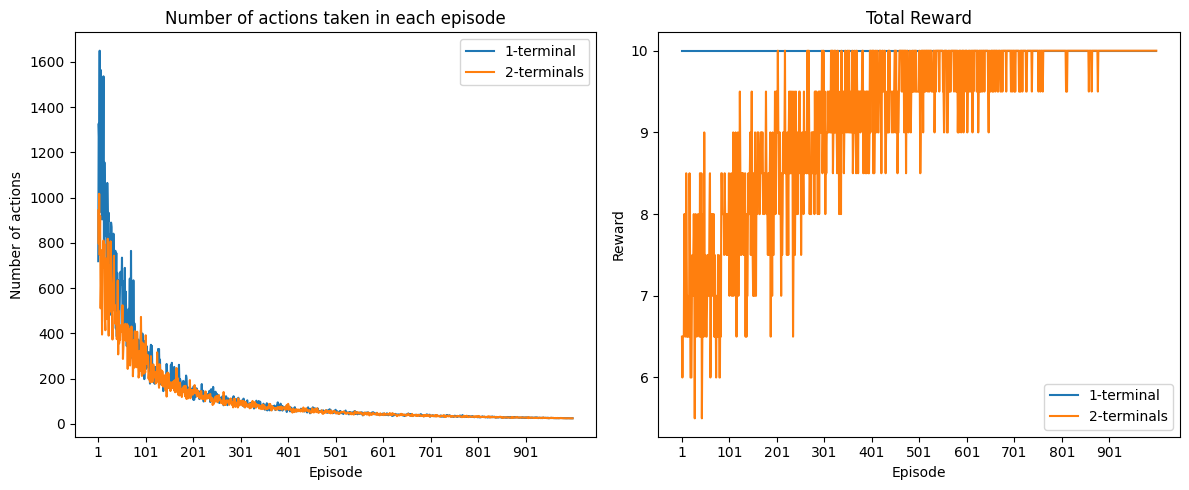

In [173]:
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
n_episodes = 1000
avg_episode_lengths_1_terminal, avg_episode_rewards_1_terminal = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_decay(n_episodes, agent)
avg_episode_lengths_2_terminals, avg_episode_rewards_2_terminals = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_2_terminals_decay(n_episodes, agent)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(range(1, n_episodes + 1), avg_episode_lengths_1_terminal, label='1-terminal')
axs[0].plot(range(1, n_episodes + 1), avg_episode_lengths_2_terminals, label='2-terminals')
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Number of actions")
axs[0].set_title("Number of actions taken in each episode")
axs[0].legend()
axs[0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Plot Q-Learning episode lengths
axs[1].plot(range(1, n_episodes + 1), avg_episode_rewards_1_terminal, label='1-terminal')
axs[1].plot(range(1, n_episodes + 1), avg_episode_rewards_2_terminals, label='2-terminals')
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Reward")
axs[1].set_title("Total Reward")
axs[1].legend()
axs[1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

# Adjust layout
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

We could solve this problem by choosing to perform more explorations at the start in order to generate q-values for paths to both goals, before then gradually choosing to perform more exploitation to find which of the two paths is best (Usama & Chang, 2020).

For our implementation, we have chosen to perform linear annealing on our epsilon from values 1 to 0.1 .

From the plots above, we see that this method indeed results in a convergence to the larger reward.

#### References
Usama, M. and Chang, D.E. (2020) Learning-driven exploration for reinforcement learning, arXiv.org. Available at: https://doi.org/10.48550/arXiv.1906.06890 (Accessed: 02 April 2024). 

#### Question 16

100%|██████████| 6/6 [03:00<00:00, 30.01s/it]


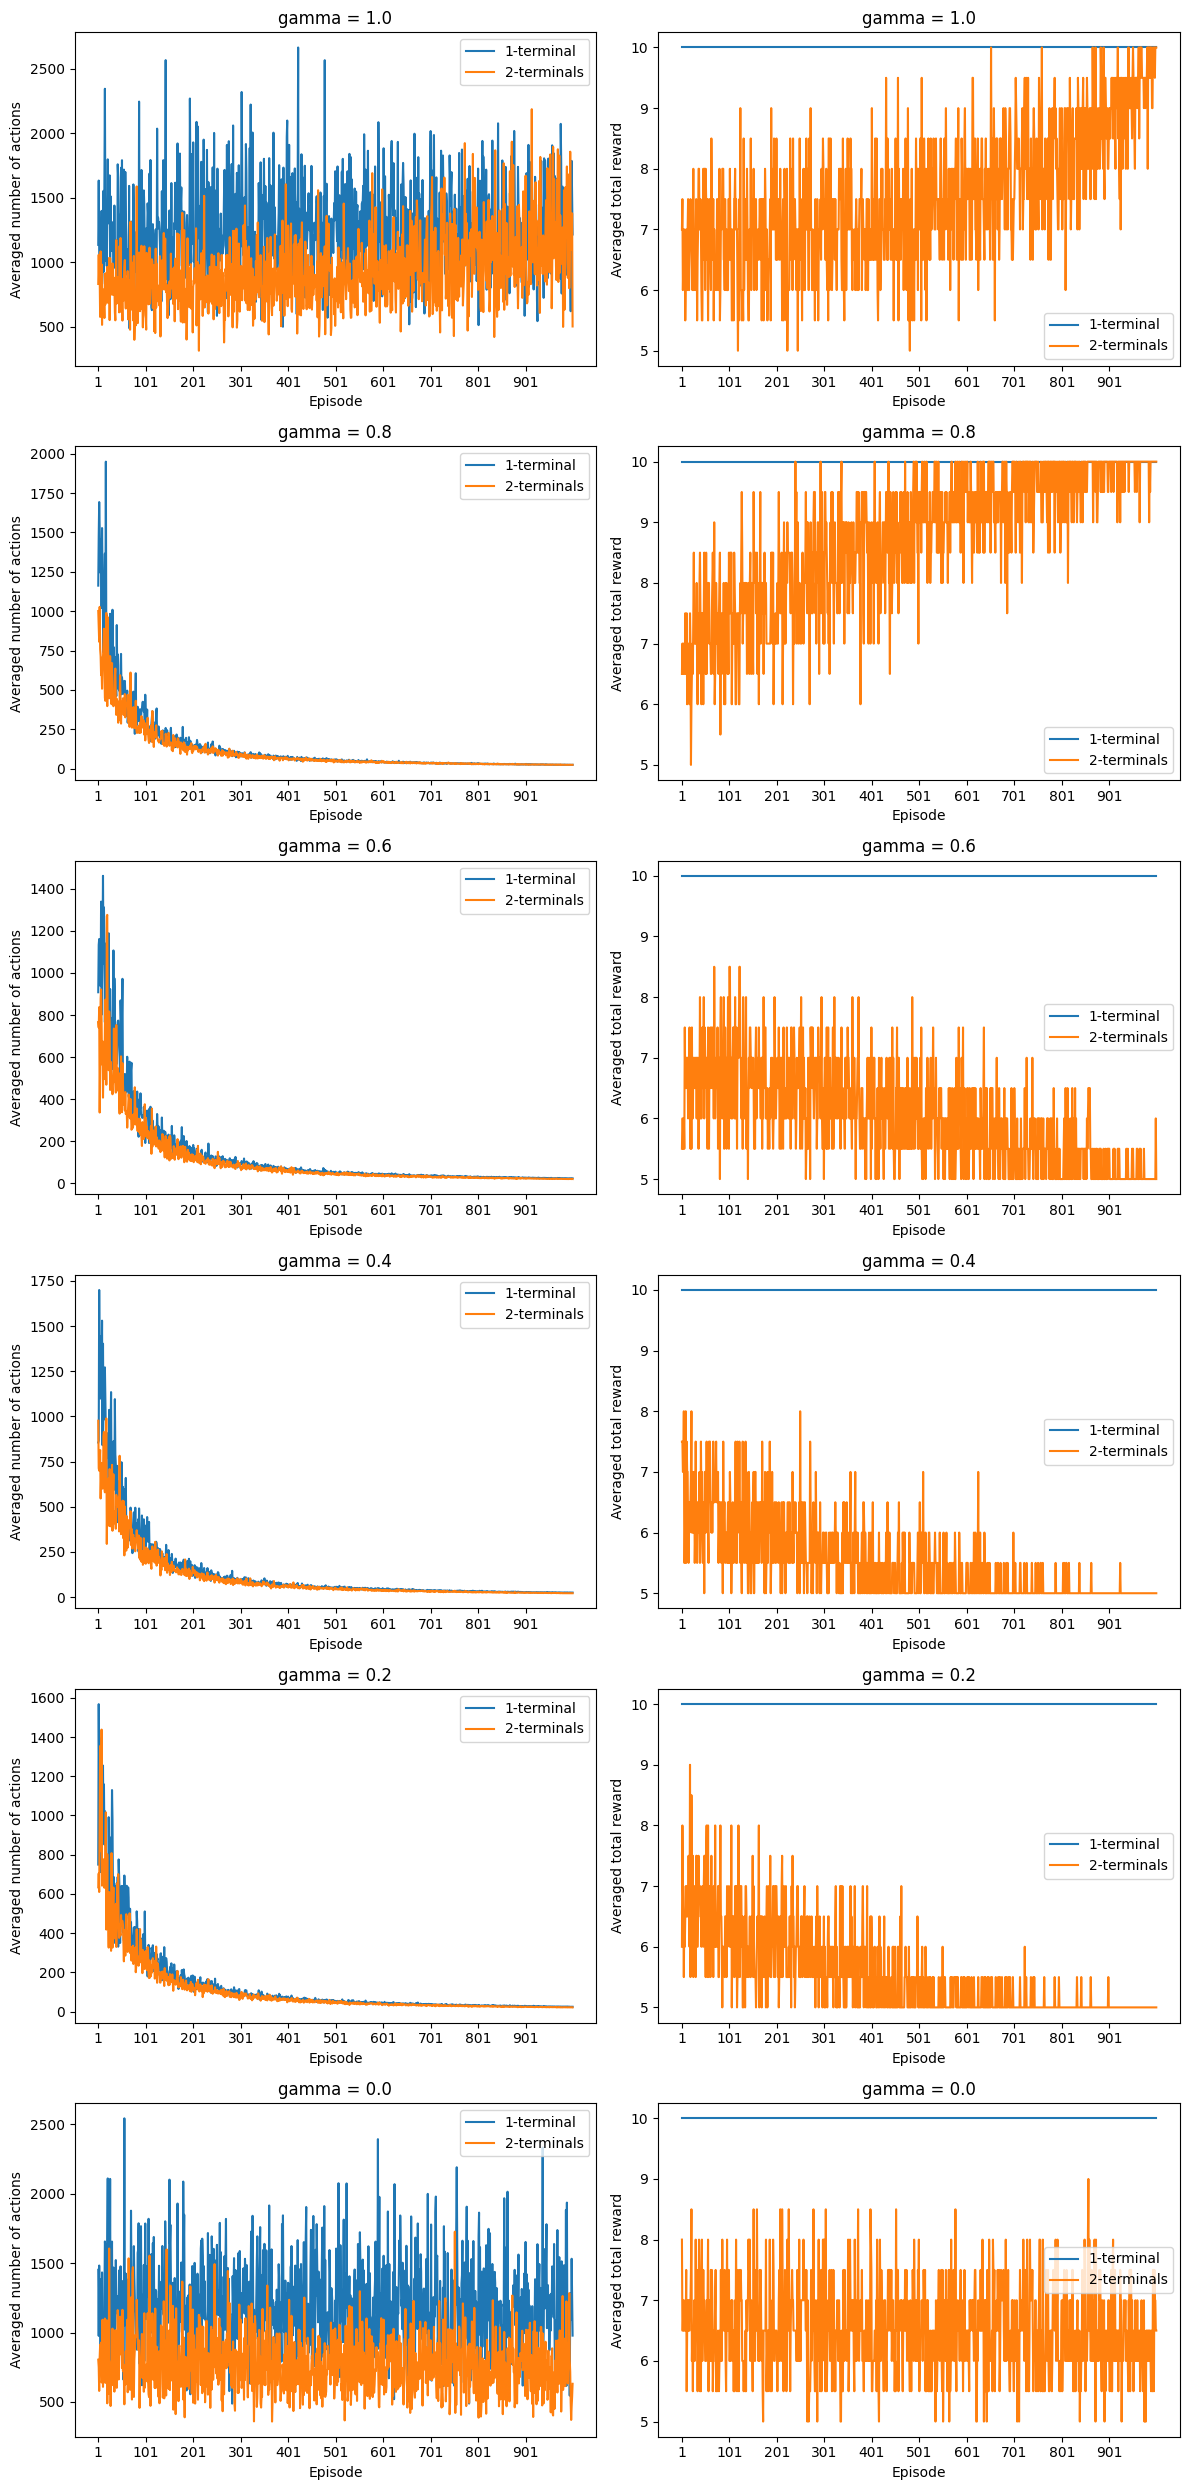

In [174]:
# Create an Agent.
agent = Agent(start_x=0, start_y=0)
n_episodes = 1000
gamma_values = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
fig, axs = plt.subplots(6, 2, figsize=(12, 25))
for i, gamma in tqdm(enumerate(gamma_values),total=len(gamma_values)):

    avg_episode_lengths_1_terminal, avg_episode_rewards_1_terminal = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_decay(n_episodes, agent, gamma=gamma)
    avg_episode_lengths_2_terminals, avg_episode_rewards_2_terminals = avg_episode_lengths_10_runs_QLearning_toy_maze_epsilon_greedy_2_terminals_decay(n_episodes, agent, gamma=gamma)

    axs[i,0].plot(range(1, n_episodes + 1), avg_episode_lengths_1_terminal, label='1-terminal')
    axs[i,0].plot(range(1, n_episodes + 1), avg_episode_lengths_2_terminals, label='2-terminals')
    axs[i,0].set_xlabel("Episode")
    axs[i,0].set_ylabel("Averaged number of actions")
    axs[i,0].set_title(f"gamma = {gamma}")
    axs[i,0].legend()
    axs[i,0].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))

    # Plot Q-Learning episode lengths
    axs[i,1].plot(range(1, n_episodes + 1), avg_episode_rewards_1_terminal, label='1-terminal')
    axs[i,1].plot(range(1, n_episodes + 1), avg_episode_rewards_2_terminals, label='2-terminals')
    axs[i,1].set_xlabel("Episode")
    axs[i,1].set_ylabel("Averaged total reward")
    axs[i,1].set_title(f"gamma = {gamma}")
    axs[i,1].legend()
    axs[i,1].set_xticks(range(1, n_episodes + 1, max(1, n_episodes // 10)))
plt.tight_layout()
plt.show()

<div style="background-color:#f1be3e">

We can derive such a value through experimentation. We start with a gamma value of 1, and then begin decreasing this value until our plots start showing convergence to the smaller reward. From the plots, we see that for values 0.6, 0.4, and 0.2, our program converges to the smaller reward. 

## 3. Open Questions
### 3.1 Reflection
#### Question 17

<div style="background-color:#f1be3e">

Using a greedy algorithm for its action selection would result in the agent being less likely to explore new possible solutions. So it would increase the chance that it would get stuck in a local optimum.

#### Question 18

<div style="background-color:#f1be3e">

The problem would be that if we don't fully understand how the agent optimises the rewards. The agent could take a different solution to the goal then intended. For example, in trying to reduce CO2 emissions, the agent could say to fully remove planes and never use them. However, that would be quite impractical since we need planes for transportation.

#### Question 19

<div style="background-color:#f1be3e">

We think it would be quite difficult to come up with a way to overcome this problem for *all* reward functions. We could combat the problem by adding a punishment mechanism for certain actions. However, this might not always be ideal as problems could be multi-faceted and involve a large amount of variables, making coming up with the punishment function and being able to know all the things that need to be taken into account quite difficult for large, complex problems.

### 3.2 Pen and Paper
#### Question 20

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

#### Question 21

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

#### Question 22

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

### 3.3 Division of Work

#### Question 23

<div style="background-color:#f1be3e">


|          Component          |  Name A   |  Name B   |  Name C   |  Name D   |
|-----------------------------|-----------|-----------|-----------|-----------|
| Code (design)               |     A     |     B     |     C     |     D     |
| Code (implementation)       |     A     |     B     |     C     |     D     |
| Code (validation)           |     A     |     B     |     C     |     D     |
| Experiments (execution)     |     A     |     B     |     C     |     D     |
| Experiments (analysis)      |     A     |     B     |     C     |     D     |
| Experiments (visualization) |     A     |     B     |     C     |     D     |
| Report (original draft)     |     A     |     B     |     C     |     D     |
| Report (reviewing, editing) |     A     |     B     |     C     |     D     |

### References

<div style="background-color:#f1be3e">

**If you made use of any non-course resources, cite them below.**
Usama, M. and Chang, D.E. (2020) Learning-driven exploration for reinforcement learning, arXiv.org. Available at: https://doi.org/10.48550/arXiv.1906.06890 (Accessed: 02 April 2024)